# Chapter 4: Simulation

## 4.1  Software Design Principles

### 4.1.1 Object-Oriented Programming (OOP)

In [ ]:
# The "Position" class holds information relevant to a single trade troughout its life.
# it can report information relevant to single trades, and check that trading activity is no erroneously recorded.

In [ ]:
# The "PortfolioHistory" class holds a list of "Position" objects, records historical balances of cash,
# and reports on performance and behavior of the portfolio overall.
# it is also responsible for computing the equity curve, return series, and any performance metrics.

In [ ]:
# The "SimpleSimulator" class holds data about the prices, signals, and preferences of different stocks.
# It is primarily responsible for stepping through time, while managing "Position" objects and recording
# events in the "PortfolioHistory" object.

In [ ]:
# in order to write efficient code,liberal use of advanced Python programming features including...
# decorators
# static methods
# pseudo-private attributes
# pass-by-reference
# magic methods
# lambda functions

### 4.1.2  Defensive Programming

In [ ]:
'''
The SimpleSimulator is responsible for managing multiple instances of the other 2 classes.
as such, it is possible and quite likely it will perform some undefined behavior at some point, such as:
- Opening and closing a position at the same instant
- Recording the same position multiple times in the portfolio history
- Recording an unclosed position
- Recording cash and portfolio histories along different sets of dates
- Having a negative cash balance
- Having multiple positions open in the same asset at the same time
'''

In [ ]:
# 4.1: assert method examples

assert 2 + 2 == 4, 'The laws of mathematics are crumbling.'
assert 2 + 2 == 5, 'You will see this message in an AssertionError'

## 4.2  Building a Simulator

### 4.2.1  Defining Supported Behanvior and Constraints

In [ ]:
#  The strategy will open and close long positions on a fixed maximum number of distinct assets simultaneously.
#   - Entry and exit dates can be asynchronous
#   - The number of shares held of each asset will be fixed over the length of the trade
#   - Cash will be divided equally among available opportunies at time of purchase
#   - Purchase of fractional shares is allowed for mathematical simplicity

In [ ]:
#  The simulator will support fees and slippage.
#   - A fixed trade fee is supported. It will be charged once to the cash balance upon purchase, but not sale, of an asset
#   - A percentage slippage amount is supported, of which will be applied adversely to the portfolio on both purchase and sale of an asset.

In [ ]:
#  The input data will consist of three date-indexed data frames with column names representing the assets under consideration.
#   - Price will be a data frame of closing prices
#   - Signal will be a data frame with integers in the set, {-1,0,1}, where -1 represents sell, 0 represents no signal, and 1 represents buy
#   - Preference will be a data frame of floats representing relative preference for each symbol at any point in time.
#     which may be entirely independent of the signal.
#     The preferences will be use to determine which assets are bought or swapped out in the case of many concurrent buy signals.
#   - The input data is assumed to have null values at the beginning of a series, but a non-null series cannot become null once it is in play,
#     as the simulator moves forward in time. (i.g. stocks can be listed, but no delisted, during the simulation time frame)

### 4.2.2  Defining a Position Object

In [1]:
# The 'Position' class and a 'position' object are defined as follows:

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from typing import Tuple, List, Dict, Callable, NewType, Any
from collections import OrderedDict, defaultdict

from pypm import metrics, signals, data_io

In [2]:
# 4.2  Position and class definition

Symbol = NewType('Symbol', str)
Dollars = NewType('Dollars', float)

DATE_FORMAT_STR = '%a %b %d, %Y'

def _pdate(date: pd.Timestamp):
    '''
    Pretty-print a datetime with just the date
    '''
    return date.strftime(DATE_FORMAT_STR)

class Position(object):
    '''
    A simple object to hold and manipulate data related to long stock trades.
    
    Allows a single buy and sell operation on an asset for a constant number of shares.
    
    The __init__ method is equivelant to a buy operation. The exit method is a sell operation.
    '''
    def __init__(self, symbol: Symbol, entry_date: pd.Timestamp, entry_price: Dollars, shares: int):
        '''
        Equivelent to buying a certian number of shares of the asset
        '''
        
        # Recorded on initializatoin
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.shares = shares
        self.symbol = symbol
        
        # Recorded on position exit
        self.exit_date: pd.Timestamp = None
        self.exit_price: Dollars = None
        
        # For easily getting current portfolio value
        self.last_date: pd.Timestamp = None
        self.last_price: Dollars = None
            
        # Updated intermediately
        self._dict_series: Dict[pd.Timestamp, Dollars] = OrderedDict()
        self.record_price_update(entry_date, entry_price)
        
        # Cache control for pd.Series representation
        self._price_series: pd.Series = None
        self._needs_update_pd_series: bool = True
    
    def exit(self, exit_date, exit_price):
        '''
        Equivelent to selling a stock holding
        '''
        assert self.entry_date != exit_date, 'Churned a position same-day.'
        assert not self.exit_date, 'Position already closed.'
        self.record_price_update(exit_date, exit_price)
        self.exit_date = exit_date
        self.exit_price = exit_price
        
    def record_price_update(self, date, price):
        '''
        Stateless function to record intermediate prices of existing positions
        '''
        self.last_date = date
        self.last_price = price
        self._dict_series[date] = price
        
        # Invalidate cache on self.price_series
        self._needs_update_pd_series = True
        
    @property
    def price_series(self) -> pd.Series:
        '''
        Returns cached read-only pd.Series
        '''
        if self._needs_update_pd_series or self._price_series is None:
            self._price_series = pd.Series(self._dict_series)
            self._needs_update_pd_series = False
        return self._price_series
    
    @property
    def last_value(self) -> Dollars:
        return self.last_price * self.shares
    
    @property
    def is_active(self) -> bool:
        return self.exit_date is None
    
    @property
    def is_closed(self) -> bool:
        return not self.is_active
    
    @property
    def value_series(self) -> pd.Series:
        '''
        Returns the value of the position over time. Ignores self.exit_date.
        Used in calculating the equity curve
        '''
        assert self.is_closed, 'Position must be closed to access this property'
        return self.shares * self.price_series[:-1]
    
    @property
    def percent_return(self) -> float:
        return (self.exit_price / self.entry_price) - 1
    
    @property
    def entry_value(self) -> Dollars:
        return self.shares * self.entry_price
    
    @property
    def exit_value(self) -> Dollars:
        return self.shares * self.exit_price
    
    @property
    def change_in_value(self) -> Dollars:
        return self.exit_value - self.entry_value
    
    @property
    def trade_length(self):
        return len(self._dict_series) - 1
    
    
    def print_position_summary(self):
        _entry_date = _pdate(self.entry_date)
        _exit_date = _pdate(self.exit_date)
        _days = self.trade_length
        
        _entry_price = round(self.entry_price, 2)
        _exit_price = round(self.exit_price, 2)
        
        _entry_value = round(self.entry_value, 2)
        _exit_value = round(self.exit_value, 2)
        
        _return = round(100 * self.percent_return, 1)
        _diff = round(self.change_in_value, 2)
        
        print(f'{self.symbol:<5}     Trade Summary')
        print(f'Date:    {_entry_date} -> {_exit_date} [{_days} days]')
        print(f'Price:   ${_entry_price} -> ${_exit_price} [{_return}%]')
        print(f'Value:   ${_entry_value} -> ${_exit_value} [${_diff}]')
        print()
        
    def __hash__(self):
        '''
        A unique position will be defined by a unique combination of an 
        entry_date and symbol, in accordance with our constraints regarding
        duplicate, variable, and compound positions
        '''
        return hash((self.entry_date, self.symbol))

In [3]:
# 4.3 Position object usage

from pypm import data_io, portfolio

symbol = 'AWU'
df = data_io.load_eod_data(symbol)
shares_to_buy = 50

for i, row in enumerate(df.itertuples()):
    date = row.Index
    price = row.close
    
    if i == 123:
        position = portfolio.Position(symbol, date, price, shares_to_buy)
    elif 123 < i < 234:
        position.record_price_update(date, price)
    elif i == 234:
        position.exit(date, price)
        
position.print_position_summary()

AWU       Trade summary
Date:     Wed Jun 30, 2010 -> Tue Dec 07, 2010 [111 days]
Price:    $220.34 -> $305.98 [38.9%]
Value:    $11017.0 -> $15299.0 [$4282.0]



### Plots

In [ ]:
figure(figsize=(14, 6), dpi=80)

plt.plot(df.index, df['close'])

In [ ]:
# First create some toy data:
x = df.index
y = df['close']

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

figure(figsize=(14, 6), dpi=80)

In [ ]:
# Create two subplots and unpack the output array immediately
figure(figsize=(8, 6), dpi=80)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x[:112], position.price_series)

### 4.2.3  Defining a Portfolio History Object

In [4]:
# The next class is called the 'PortfolioHistory'.
# This class will primarily be an organized container for position objects.
# With the position objects, it will be able to derive the equity curve and numerous performance metrics.

In [5]:
class PortfolioHistory (object):
    '''
    Holds Position objects and keeps track of portfolio variables.
    Produces summary statistics
    '''
    def __init__(self):
        # Keep track of positions, recorded in this list after close
        self.position_history: List[Position] = []
        self._logged_positions: Set[Position] = set()
            
        # Keep track of the last seen date
        self.last_date: pd.Timestamp = pd.Timestamp.min
        
        # Read-only fields
        self._cash_history: Dict[pd.Timestamp, Dollars] = dict()
        self._simulation_finished = False
        self._spy: pd.DataFrame = pd.DataFrame()
        self._spy_log_returns: pd.Series = pd.Series()
            
    def add_to_history(self, position: Position):
        _log = self._logged_positions
        assert not position in _log, 'Recorded the same position twice.'
        assert position.is_closed, 'Position is not closed.'
        self._logged_positions.add(position)
        self.position_history.append(position)
        self.last_date = max(self.last_date, position.last_date)
        
    def record_cash(self, date, cash):
        self._cash_history[date] = cash
        self.last_date = max(self.last_date, date)
        
    @staticmethod
    def _as_oseries(d: Dict[pd.Timestamp, Any]) -> pd.Series:
        return pd.Series(d).sort_index()
    
    def _compute_cash_series(self):
        self._cash_series = self._as_oseries(self._cash_history)
        
    @property
    def cash_series(self) -> pd.Series:
        return self._cash_series
    
    def _compute_portfolio_value_series(self):
        value_by_date = defaultdict(float)
        last_date = self.last_date
        
        # Add up value of assets
        for position in self.position_history:
            for date, value in position.vlaue_series.items():
                value_by_date[date] += value
        
        # Make sure all dates in cash_series are present
        for date in self.cash_series.index:
            value_by_date[date] += 0
            
        self._portfolio_value_series = self._as_oseries(value_by_date)
        
    @property
    def portfolio_value_series(self):
        return self._portfolio_value_series
    
    def _compute_equity_series(self):
        c_series = self.cash_series
        p_series = self.portfolio_value_series
        assert all(c_series.index == p_series.index), 'portfolio_series has dates not in cash_series'
        self._equity_series = c_series + p_series
        
    @property
    def equity_series(self):
        return self._equity_series
    
    def _compute_log_return_series(self):
        self._log_return_sereis = metrics.calculate_log_return_series(self.equity_series)
        
    @property
    def log_return_series(self):
        return self._log_return_series
    
    def _assert_finished(self):
        assert self._simulation_finished, \
            'Simulation must be finished by running self.finish() in order ' + \
            'to access this method or property.'
    
    def finish(self):
        '''
        Notate that the simulation is finished and compute read-only values
        '''
        self._simulation_finished = True
        self._compute_cash_series()
        self._compute_portfolio_value_series()
        self._compute_equity_series()
        self._compute_log_return_series()
        self._assert_finished()
        
    def compute_portfolio_size_series(self) -> pd.Series:
        size_by_date = defaultdict(int)
        for position in self.position_history:
            for date in position.value_series.index:
                size_by_date[date] += 1
        return self._as_oseries(size_by_date)
    
    @property
    def spy(self):
        if self._spy.empty:
            self._spy = data_io.load_spy_data()
        return self._spy
    
    @property
    def spy_log_returns(self):
        if self._spy_log_returns.empty:
            close = self.spy['close']
            self._spy_log_returns = metrics.calculate_log_return_series(close)
        return self._spy_log_returns
    
    @property
    def percent_return(self):
        return metrics.calculate_percent_return(self.equity_series)
    
    @property
    def spy_percent_return(self):
        return metrics.calculate_percent_return(self.spy['close'])
    
    @property
    def cagr(self):
        return metrics.calculate_cagr(self.equity_series)
    
    @property
    def volatility(self):
        return metrics.calculate_annualized_volatility(self.log_returns_sereis)
    
    @property
    def sharpe_ratio(self):
        return metrics.calculate_sharpe_ratio(self.equity_series)
    
    @property
    def spy_cagr(self):
        return metrics.calculate_cagr(self.spy['close'])
    
    @property
    def excess_cagr(self):
        return self.cagr - self.spy_cagr
    
    @property
    def jensens_alpha(self):
        return metrics.calculate_jensens_alpha(
            self.log_return_series,
            self.spy_log_returns,
        )
    
    @property
    def dollar_max_drawdown(self):
        return metrics.calculate_max_drawdown(self.equity_series, 'dollar')
    
    @property
    def percent_max_drawdown(self):
        return metrics.calculate_max_drawdown(self.equity_series, 'percent')
    
    @property
    def log_max_drawdown_ratio(self):
        return metrics.calculate_log_max_drawdown_ratio(self.equity_series)
    
    @property
    def number_of_trades(self):
        return len(self.position_history)
    
    @property
    def average_active_trades(self):
        return self.compute_portfolio_size_series().mean()
    
    @property
    def final_cash(self):
        self._assert_finished()
        return self.cash_series[-1]
    
    @property
    def final_equity(self):
        self._assert_finished()
        return self.equity_series[-1]
    
    def print_position_summaries(self):
        for position in self.position_history:
            position.print_position_summary()
            
    def print_summary(self):
        self._assert_finished()
        s = f'Equity: ${self.final_equity:.2f}\n' \
            f'Percent Return: {100*self.percent_return:.2f}%\n\n' \
            f'S&P 500 Return: {100*self.spy_percent_return:.2f}%\n\n' \
            f'Number of trades: {self.number_of_trades}\n' \
            f'Average active trades: {self.average_active_trades:.2f}\n\n' \
            f'CAGR: {100*self.cagr:.2f}%\n' \
            f'S&P 500 CAGR: {100*self.spy_cagr:.2f}%\n' \
            f'Excess CAGR: {100*self.excess_cagr: .2f}%\n\n' \
            f'Annualized Volatility: {100*self.volatility: .2f}%\n' \
            f'Sharpe Ratio: {self.sharpe_ratio: .2f}\n' \
            f'Jensen\'s Alpha: {self.jensens_alpha: .6f}\n\n' \
            f'Dollar Max Drawdown: ${self.dollar_max_drawdown: .2f}\n' \
            f'Percent Max Drawdown: {100*self.percent_max_drawdown: .2f}%\n' \
            f'Log Max Drawdown Ratio: {self.log_max_drawdown_ratio: .2f}\n'
        
        print(s)
        
    def plot(self, show=True) -> plt.Figure:
        '''
        Plots equity, cash and portfolio value curves
        '''
        self._assert_finished()
        
        figure, axes = plt.subplots(nrows=3, ncols=1)
        figure.tight_layout(pad=3.0)
        axes[0].plot(self.equity_series)
        axes[0].set_title('Equity')
        axes[0].grid()
        
        axes[1].plot(self.cash_series)
        axes[1].set_title('Cash')
        axes[1].grid()
        
        axes[2].plot(self.portfolio_value_sereis)
        axes[2].set_title('Portfolio Value')
        axes[3].grid
        
        if show:
            plt.show()
            
        return figure

AWU       Trade summary
Date:     Wed Jun 30, 2010 -> Tue Apr 30, 2019 [2222 days]
Price:    $220.34 -> $386.26 [75.3%]
Value:    $10000.0 -> $17530.18 [$7530.18]

Equity: $17530.18
Percent Return: 75.30%
S&P 500 Return: 183.25%

Number of trades: 1
Average active trades: 1.00

CAGR: 5.78%
S&P 500 CAGR: 10.99%
Excess CAGR: -5.21%

Annualized Volatility: 29.97%
Sharpe Ratio: 0.19
Jensen's Alpha: -0.000197

Dollar Max Drawdown: $9006.08
Percent Max Drawdown: 60.08%
Log Max Drawdown Ratio: -0.36



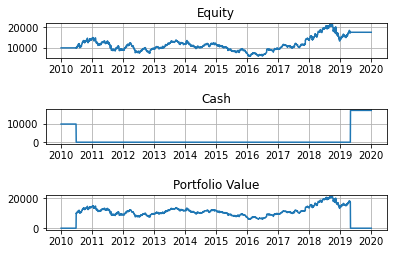

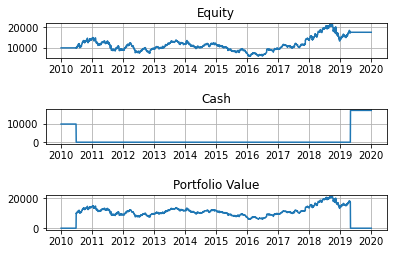

In [6]:
# 4.5 Portfolio history object usage
import pandas as pd
from pypm import data_io
from pypm.portfolio import Position, PortfolioHistory

symbol = 'AWU'
df = data_io.load_eod_data(symbol)

portfolio_history = PortfolioHistory()
initial_cash = cash = 10000

for i, row in enumerate(df.itertuples()):
    date = row.Index
    price = row.close

    if i == 123:
        # Figure out how many shares to buy
        shares_to_buy = initial_cash / price 

        # Record the position
        position = Position(symbol, date, price, shares_to_buy)

        # Spend all of your cash
        cash -= initial_cash

    elif 123 < i < 2345:
        position.record_price_update(date, price)

    elif i == 2345:
        # Sell the asset
        position.exit(date, price)

        # Get your cash back
        cash += price * shares_to_buy

        # Record the position
        portfolio_history.add_to_history(position)

    # Record cash at every step
    portfolio_history.record_cash(date, cash)

portfolio_history.finish()

portfolio_history.print_position_summaries()

portfolio_history.print_summary()

portfolio_history.plot()

###  Defining a Simulator

In [7]:
from typing import Tuple, List, Dict, Callable, NewType, Any, Iterable

import pandas as pd
import matplotlib.pyplot as plt

from pypm import metrics, signals, data_io
from pypm.portfolio import PortfolioHistory, Position, Symbol, Dollars

from collections import OrderedDict, defaultdict

class SimpleSimulator(object):
    '''
    A simple trading simulator to work with the PortfolioHistory class
    '''
    def __init__(self, initial_cash: float=10000, max_active_positions: int=5, percent_slippage: float=0.0005, trade_fee: float=1):
        
        ## Set simulation parameters
        
        # Initial cash in portoflio
        # self.cash will fluctuate
        self.initial_cash = self.cash = initial_cash
        
        #maximum number of different assets that can be help simultaneously
        self.max_active_positions: int = max_active_positions
            
        # The percentage difference between closing price and fill price for the
        # position to simulate adverse effects of market orders
        self.percent_slippage = percent_slippage
        
        # The fixed fee in order to open a posiiton in dollar terms
        self.trade_fee = trade_fee
        
        # Keep track of live trades
        self.active_positions_by_symbol: Dict[Symbol, Position] = OrderedDict()
            
        # Keep tract of portoflio history like cash, equity, and positions
        self.potfolio_history = PortfolioHistory()
        
    @property
    def active_positions_count(self):
        return len(self.active_positions_by_symbol)
    
    @property
    def free_positon_slots(self):
        return self.max_active_positions - self.active_positions_count
    
    @property
    def active_symbols(self) -> List[Symbol]:
        return list(self.active_positions_by_symbol.keys())
    
    def print_initial_parameters(self):
        s = f'Initial Cash: ${self.initial_cash} \n' \
            f'Maximum Number of Assets: {self.max_active_positions}\n'
        print(s)
        return s
    
    @staticmethod
    def make_tuple_lookup(columns) -> Callable[[str, str], int]:
        '''
        Map a multi-index dataframe to an intertuples-like object.
        
        
        The index of the dataframe is always the zero-th element.
        '''
        
        # col is a hierarchical column index represented by a tuple of strings
        tuple_lookup: Dict[Tuple[str, str,], int] = {
            col: i + 1 for i, col in enumerate(columns)
        }
        
        return lambda symbol, metric: tuple_lookup[(symbol, metric)]
    
    @staticmethod
    def make_all_valid_lookup(_idx: Callable):
        '''
        Return a function that checks for valid data, given a lookup function.
        '''
        return lambda row, symbol: (
            not pd.insa(row[_idx(symbol, 'pref')]) and \
            not pd.insa(row[_idx(symbol, 'signal')]) and \
            not pd.insa(row[_idx(symbol, 'price')])
        )
    
    def buy_to_open(self, symbol, date, price):
        '''
        Keep track of new position, make sure it isn't an existing position.
        Verify you have cash.
        '''
        
        # Figure out how much we are willing to spend
        cash_to_spend = self.cash / self.free_position_slots
        cash_to_spend -= self.trade_fee
        
        # Calculate buy_price and number of shares. Fractional shares allowed.
        purchase_price = (1 + self.percent_slippage) * price
        shares = cash_to_spend / purchase_price
        
        # Spend the cash
        self.cash -= cash_to_spend + self.trade_fee
        assert self.cash >= 0, 'Spent cash you do not have.'
        self.portoflio_history.record_cash(date, self.cash)
        
        # Record the position
        positions_by_symbol = self.active_positions_by_symbol
        assert not symbol in positions_by_symbol, 'Symbol already in portfolio.'
        position = Position(symbol, date, purchase_price, shares)
        positions_by_symbol[symbol] = position
        
    def sell_to_close(self, symbol, date, price):
        '''
        Keep track of exit price, recover cash, close posiiton, and record it in portfolio history.
        
        Will raise a KeyError if symbol isn't an active position.
        '''
        
        # Exit the position
        positions_by_symbol = self.active_positions_by_symbol
        position = positions_by_symbol[symbol]
        position.exit(date, price)
        
        # Receive the cash
        sale_value = position.last_value * (1 - self.percent_slippage)
        self.cash += sale_value
        self.portfolio_history.record_cash(date, self.cash)
        
        # Record in portfolio history
        self.portfolio_history.add_to_history(position)
        del positions_by_symbol[symbol]
        
    @staticmethod
    def _assert_equal_columns(*args: Iterable[pd.DataFrame]):
        column_names = set(args[0].columns.values)
        for arg in args[1:]:
            assert set(arg.columns.values) == column_names, 'Found unequal column names in input data frames.'
            
    def simulate(self, price: pd.DataFrame, signal: pd.DataFrame, preference: pd.DataFrame):
        '''
        Runs the simulation.
        
        price, signal, and preference are data frames with the column names
        represented by the same set of stock symbols.
        '''
        
        # Create a hierarchical data frame to loop through
        self._assert_equal_columns(price, signal, preference)
        df = data_io.concatenate_metrics({
            'price': price,
            'signal': signal,
            'pref': preference,
        })
        
        # Get list of symbols
        all_symbols = list(set(price.columns.values))
        
        # Get lookup functions
        _idx = self.make_tuple_lookup(df.columns)
        _all_valid = self.make_all_valid_lookup(_idx)
        
        # Store some variables
        active_positions_by_symbol = self.active_positions_by_symbol
        max_active_positions = self.max_active_positions
        
        # Iterating over all dates.
        # itertuples() is significantly faster than iterrows(), it howere comes
        # at the cost of being able to index easily. In order to get around this
        # we use a tuple lookp function: _idx
        for row in df.intertuples():
            
            # date index is always first element of tuple row
            date = row[0]
            
            # Get symbols with valid and tradable data
            symbols: List[str] = [s for s in all_symbols if _all_valid(row, s)]
                
            # Iterate over active positions and sell stocks with a sell signal
            _active = self.active_symbols
            to_exit = [s for s in _active if row[_idx(s, 'signal')] == -1]
            for s in to_exit:
                sell_price = row[_idx(s, 'price')]
                self.sell_to_close(s, date, sell_price)
                
            # Get up to max_active_positions symbols with a buy signal in 
            # decreasing order of preference
            to_buy = [
                s for s in symbols if \
                    row[_idx(s, 'signal')] == 1 and \
                    not s in active_positions_by_symbol
            ]
            to_buy.sort(key=lambda s: row[_idx(s, 'pref')], reverse=True)
            to_buy = to_buy[:max_active_positions]
            
            for s in to_buy:
                buy_price = row[_idx(s, 'price')]
                buy_preference = row[_idx(s, 'pref')]
                
                # If we have some empty slots, just buy the asset outright
                if self.active_positions_count < max_active_positions:
                    self.buy_to_open(s, date, buy_price)
                    continue
                    
                # If we are holding max_active_positions, evaluate a swap based on preference
                _active = self.active_symbols
                active_prefs = [(s, row[_idx(s, 'pref')]) for s in _active]
                
                _min = min(active_prefs, key=lambda k: k[1])
                min_active_symbol, min_active_preference = _min
                
                # If a more preferable symbol exists, then sell an old one
                if min_active_preference < buy_preference:
                    sell_price = row[_idx(min_active_symbol, 'price')]
                    self.sell_to_close(min_active_symbol, date, sell_price)
                    self.buy_to_open(s, date, buy_price)
                    
            # Update price data everwhere
            for s in self.active_symbols:
                price = row[_idx(s, 'price')]
                position = active_positions_by_symbol[s]
                position.record_price_update(date, price)
                
        # Sell all positions and mark simulation as complete
        for s in self.active_symbols:
            self.sell_to_close(s, date, row[_idx(s, 'price')])
        self.portfolio_history.finish()
        
    

MTZB      Trade summary
Date:     Wed Feb 03, 2010 -> Thu Feb 04, 2010 [1 days]
Price:    $83.77 -> $80.94 [-3.4%]
Value:    $1999.55 -> $1931.96 [$-67.59]

VHE       Trade summary
Date:     Wed Feb 03, 2010 -> Thu Feb 04, 2010 [1 days]
Price:    $155.6 -> $151.04 [-2.9%]
Value:    $1999.8 -> $1941.22 [$-58.58]

PQCE      Trade summary
Date:     Thu Feb 04, 2010 -> Fri Feb 05, 2010 [1 days]
Price:    $161.2 -> $159.01 [-1.4%]
Value:    $1929.99 -> $1903.76 [$-26.23]

XJJI      Trade summary
Date:     Fri Feb 05, 2010 -> Mon Feb 08, 2010 [1 days]
Price:    $87.81 -> $86.93 [-1.0%]
Value:    $1901.81 -> $1882.67 [$-19.14]

BMG       Trade summary
Date:     Mon Feb 08, 2010 -> Tue Feb 16, 2010 [5 days]
Price:    $57.88 -> $63.81 [10.2%]
Value:    $1880.73 -> $2073.45 [$192.73]

XSOQ      Trade summary
Date:     Tue Feb 16, 2010 -> Tue Feb 23, 2010 [5 days]
Price:    $77.1 -> $77.29 [0.2%]
Value:    $2071.42 -> $2076.56 [$5.14]

TRE       Trade summary
Date:     Thu Feb 04, 2010 -> Fri Mar

Date:     Fri Oct 29, 2010 -> Mon Nov 01, 2010 [1 days]
Price:    $58.2 -> $57.63 [-1.0%]
Value:    $2889.33 -> $2861.08 [$-28.25]

CHWK      Trade summary
Date:     Thu Sep 23, 2010 -> Tue Nov 02, 2010 [28 days]
Price:    $77.73 -> $86.69 [11.5%]
Value:    $2414.77 -> $2693.16 [$278.39]

EUZ       Trade summary
Date:     Fri Oct 15, 2010 -> Thu Nov 04, 2010 [14 days]
Price:    $74.45 -> $87.09 [17.0%]
Value:    $2177.63 -> $2547.45 [$369.81]

OBAK      Trade summary
Date:     Tue Oct 19, 2010 -> Fri Nov 05, 2010 [13 days]
Price:    $61.17 -> $60.33 [-1.4%]
Value:    $2814.49 -> $2775.81 [$-38.68]

KSR       Trade summary
Date:     Thu Nov 04, 2010 -> Mon Nov 08, 2010 [2 days]
Price:    $175.69 -> $170.62 [-2.9%]
Value:    $2545.17 -> $2471.75 [$-73.42]

PYTC      Trade summary
Date:     Wed Nov 03, 2010 -> Tue Nov 09, 2010 [4 days]
Price:    $121.37 -> $113.67 [-6.3%]
Value:    $2690.82 -> $2520.09 [$-170.73]

SGVQ      Trade summary
Date:     Thu Oct 28, 2010 -> Tue Nov 09, 2010 [8 d

MEF       Trade summary
Date:     Wed Mar 16, 2011 -> Mon Apr 18, 2011 [23 days]
Price:    $143.44 -> $144.89 [1.0%]
Value:    $2321.84 -> $2345.28 [$23.44]

XYCJ      Trade summary
Date:     Wed Mar 02, 2011 -> Wed Apr 20, 2011 [35 days]
Price:    $45.51 -> $50.19 [10.3%]
Value:    $2740.48 -> $3022.12 [$281.63]

WFS       Trade summary
Date:     Tue Apr 05, 2011 -> Thu Apr 21, 2011 [12 days]
Price:    $192.0 -> $207.45 [8.0%]
Value:    $2967.15 -> $3205.98 [$238.83]

JMS       Trade summary
Date:     Mon Apr 18, 2011 -> Thu Apr 21, 2011 [3 days]
Price:    $129.85 -> $138.27 [6.5%]
Value:    $2343.11 -> $2494.95 [$151.84]

NZSR      Trade summary
Date:     Mon Apr 18, 2011 -> Tue Apr 26, 2011 [5 days]
Price:    $143.72 -> $155.58 [8.3%]
Value:    $2614.34 -> $2830.05 [$215.7]

TRE       Trade summary
Date:     Thu Apr 21, 2011 -> Thu Apr 28, 2011 [4 days]
Price:    $148.18 -> $156.66 [5.7%]
Value:    $2848.54 -> $3011.47 [$162.93]

EUZ       Trade summary
Date:     Thu Apr 21, 2011 ->

VLOZ      Trade summary
Date:     Wed Jul 27, 2011 -> Fri Jul 29, 2011 [2 days]
Price:    $178.83 -> $179.05 [0.1%]
Value:    $3008.36 -> $3012.07 [$3.71]

KGO       Trade summary
Date:     Thu Jul 28, 2011 -> Fri Jul 29, 2011 [1 days]
Price:    $175.97 -> $174.16 [-1.0%]
Value:    $2770.0 -> $2741.54 [$-28.46]

ZWH       Trade summary
Date:     Fri Jun 24, 2011 -> Mon Aug 01, 2011 [25 days]
Price:    $207.88 -> $208.22 [0.2%]
Value:    $2773.19 -> $2777.67 [$4.48]

BMG       Trade summary
Date:     Thu Jul 28, 2011 -> Tue Aug 02, 2011 [3 days]
Price:    $78.73 -> $75.37 [-4.3%]
Value:    $2795.25 -> $2675.98 [$-119.27]

HECP      Trade summary
Date:     Wed Jul 27, 2011 -> Tue Aug 02, 2011 [4 days]
Price:    $183.71 -> $173.07 [-5.8%]
Value:    $2841.48 -> $2676.88 [$-164.6]

SGVQ      Trade summary
Date:     Mon Aug 01, 2011 -> Tue Aug 02, 2011 [1 days]
Price:    $102.24 -> $101.54 [-0.7%]
Value:    $2775.28 -> $2756.25 [$-19.03]

RQG       Trade summary
Date:     Fri Jul 29, 2011 ->

Price:    $97.72 -> $99.49 [1.8%]
Value:    $2845.19 -> $2896.76 [$51.57]

HER       Trade summary
Date:     Thu Feb 02, 2012 -> Tue Mar 13, 2012 [27 days]
Price:    $179.97 -> $203.65 [13.2%]
Value:    $2687.53 -> $3041.15 [$353.62]

HXX       Trade summary
Date:     Tue Mar 06, 2012 -> Tue Mar 13, 2012 [5 days]
Price:    $206.66 -> $222.06 [7.5%]
Value:    $3341.79 -> $3590.76 [$248.97]

ZGL       Trade summary
Date:     Tue Mar 20, 2012 -> Thu Mar 22, 2012 [2 days]
Price:    $59.1 -> $58.59 [-0.9%]
Value:    $3312.79 -> $3284.23 [$-28.56]

UFT       Trade summary
Date:     Tue Mar 20, 2012 -> Mon Mar 26, 2012 [4 days]
Price:    $262.62 -> $279.19 [6.3%]
Value:    $3313.79 -> $3522.86 [$209.07]

SIP       Trade summary
Date:     Tue Mar 06, 2012 -> Thu Apr 05, 2012 [22 days]
Price:    $167.94 -> $158.78 [-5.5%]
Value:    $3500.07 -> $3309.09 [$-190.98]

VLOZ      Trade summary
Date:     Thu Mar 29, 2012 -> Thu Apr 05, 2012 [5 days]
Price:    $213.13 -> $215.01 [0.9%]
Value:    $3520.

KUAQ      Trade summary
Date:     Fri Jun 01, 2012 -> Wed Jun 13, 2012 [8 days]
Price:    $316.95 -> $332.37 [4.9%]
Value:    $2593.25 -> $2719.43 [$126.18]

SGVQ      Trade summary
Date:     Fri Jun 01, 2012 -> Thu Jun 14, 2012 [9 days]
Price:    $116.4 -> $124.31 [6.8%]
Value:    $3731.22 -> $3984.84 [$253.62]

FJKV      Trade summary
Date:     Wed May 30, 2012 -> Mon Jun 18, 2012 [13 days]
Price:    $112.26 -> $118.19 [5.3%]
Value:    $3355.39 -> $3532.75 [$177.37]

ZOE       Trade summary
Date:     Fri Jun 01, 2012 -> Mon Jun 18, 2012 [11 days]
Price:    $50.01 -> $52.89 [5.7%]
Value:    $3075.42 -> $3252.2 [$176.78]

RQG       Trade summary
Date:     Fri Jun 01, 2012 -> Wed Jun 20, 2012 [13 days]
Price:    $263.42 -> $286.26 [8.7%]
Value:    $2499.07 -> $2715.73 [$216.67]

XSOQ      Trade summary
Date:     Thu Jun 14, 2012 -> Thu Jun 28, 2012 [10 days]
Price:    $64.24 -> $60.98 [-5.1%]
Value:    $3981.85 -> $3779.66 [$-202.19]

UZS       Trade summary
Date:     Wed Jun 13, 2012 -


FJZC      Trade summary
Date:     Mon Sep 17, 2012 -> Tue Sep 18, 2012 [1 days]
Price:    $206.9 -> $204.63 [-1.1%]
Value:    $3599.95 -> $3560.39 [$-39.56]

RALO      Trade summary
Date:     Tue Sep 18, 2012 -> Wed Sep 19, 2012 [1 days]
Price:    $221.83 -> $221.08 [-0.3%]
Value:    $3557.61 -> $3545.57 [$-12.04]

OZMT      Trade summary
Date:     Wed Sep 12, 2012 -> Wed Sep 19, 2012 [5 days]
Price:    $135.31 -> $145.51 [7.5%]
Value:    $3999.66 -> $4301.24 [$301.58]

VBB       Trade summary
Date:     Wed Sep 19, 2012 -> Thu Sep 20, 2012 [1 days]
Price:    $125.89 -> $126.96 [0.8%]
Value:    $3542.8 -> $3572.83 [$30.03]

LJGB      Trade summary
Date:     Thu Sep 20, 2012 -> Fri Sep 21, 2012 [1 days]
Price:    $209.21 -> $208.06 [-0.6%]
Value:    $3570.04 -> $3550.34 [$-19.7]

ZEA       Trade summary
Date:     Tue Sep 18, 2012 -> Mon Sep 24, 2012 [4 days]
Price:    $110.61 -> $110.32 [-0.3%]
Value:    $3598.95 -> $3589.67 [$-9.28]

LJGB      Trade summary
Date:     Mon Sep 24, 2012 -

RVWV      Trade summary
Date:     Tue Apr 02, 2013 -> Fri Apr 05, 2013 [3 days]
Price:    $97.42 -> $98.15 [0.8%]
Value:    $4680.23 -> $4715.36 [$35.13]

YPDA      Trade summary
Date:     Wed Apr 03, 2013 -> Fri Apr 05, 2013 [2 days]
Price:    $118.11 -> $117.43 [-0.6%]
Value:    $2517.6 -> $2503.13 [$-14.47]

KTVL      Trade summary
Date:     Wed Apr 03, 2013 -> Fri Apr 05, 2013 [2 days]
Price:    $109.38 -> $108.45 [-0.9%]
Value:    $3580.58 -> $3549.98 [$-30.6]

DVRL      Trade summary
Date:     Wed Apr 03, 2013 -> Fri Apr 05, 2013 [2 days]
Price:    $99.84 -> $98.35 [-1.5%]
Value:    $5380.68 -> $5300.38 [$-80.29]

MTZB      Trade summary
Date:     Fri Apr 05, 2013 -> Thu Apr 11, 2013 [4 days]
Price:    $70.62 -> $74.6 [5.6%]
Value:    $5296.73 -> $5595.62 [$298.89]

PUO       Trade summary
Date:     Fri Apr 05, 2013 -> Mon Apr 15, 2013 [6 days]
Price:    $156.5 -> $150.83 [-3.6%]
Value:    $2500.88 -> $2410.3 [$-90.58]

TGXX      Trade summary
Date:     Fri Apr 05, 2013 -> Mon Ap

MHNG      Trade summary
Date:     Fri May 02, 2014 -> Wed May 14, 2014 [8 days]
Price:    $150.36 -> $151.36 [0.7%]
Value:    $6014.12 -> $6054.31 [$40.19]

HESC      Trade summary
Date:     Wed May 14, 2014 -> Tue May 20, 2014 [4 days]
Price:    $41.74 -> $39.83 [-4.6%]
Value:    $6050.28 -> $5773.31 [$-276.98]

WNE       Trade summary
Date:     Mon Apr 28, 2014 -> Tue May 20, 2014 [16 days]
Price:    $227.33 -> $228.68 [0.6%]
Value:    $4274.07 -> $4299.39 [$25.31]

TQKA      Trade summary
Date:     Tue May 20, 2014 -> Fri May 23, 2014 [3 days]
Price:    $216.67 -> $220.15 [1.6%]
Value:    $4296.24 -> $4365.27 [$69.04]

NZSR      Trade summary
Date:     Tue May 20, 2014 -> Wed May 28, 2014 [5 days]
Price:    $139.71 -> $141.8 [1.5%]
Value:    $5769.42 -> $5855.74 [$86.32]

XAU       Trade summary
Date:     Fri May 23, 2014 -> Thu May 29, 2014 [3 days]
Price:    $71.3 -> $73.16 [2.6%]
Value:    $4362.09 -> $4476.16 [$114.07]

IEZI      Trade summary
Date:     Fri Apr 11, 2014 -> Mon J

Date:     Tue Oct 07, 2014 -> Thu Oct 09, 2014 [2 days]
Price:    $187.41 -> $185.54 [-1.0%]
Value:    $6148.73 -> $6087.25 [$-61.47]

XYCJ      Trade summary
Date:     Thu Oct 09, 2014 -> Fri Oct 10, 2014 [1 days]
Price:    $76.83 -> $76.1 [-0.9%]
Value:    $6083.21 -> $6025.54 [$-57.67]

OZI       Trade summary
Date:     Thu Oct 09, 2014 -> Fri Oct 10, 2014 [1 days]
Price:    $176.21 -> $170.98 [-3.0%]
Value:    $6270.24 -> $6084.21 [$-186.04]

NKP       Trade summary
Date:     Tue Oct 07, 2014 -> Fri Oct 10, 2014 [3 days]
Price:    $145.7 -> $145.17 [-0.4%]
Value:    $5493.51 -> $5473.42 [$-20.09]

NEGH      Trade summary
Date:     Fri Oct 10, 2014 -> Mon Oct 13, 2014 [1 days]
Price:    $230.18 -> $227.93 [-1.0%]
Value:    $6021.52 -> $5962.79 [$-58.73]

SXQ       Trade summary
Date:     Fri Oct 10, 2014 -> Mon Oct 13, 2014 [1 days]
Price:    $206.0 -> $202.01 [-1.9%]
Value:    $5469.69 -> $5363.67 [$-106.02]

CUU       Trade summary
Date:     Tue Oct 07, 2014 -> Mon Oct 13, 2014 [4

Value:    $5884.3 -> $5921.91 [$37.61]

TUMH      Trade summary
Date:     Fri Jan 23, 2015 -> Fri Jan 30, 2015 [5 days]
Price:    $220.02 -> $212.23 [-3.5%]
Value:    $7898.74 -> $7619.08 [$-279.66]

FSVO      Trade summary
Date:     Fri Jan 30, 2015 -> Wed Feb 04, 2015 [3 days]
Price:    $189.97 -> $192.05 [1.1%]
Value:    $5018.88 -> $5073.7 [$54.82]

UAIG      Trade summary
Date:     Wed Feb 04, 2015 -> Fri Feb 06, 2015 [2 days]
Price:    $943.54 -> $928.96 [-1.5%]
Value:    $5070.16 -> $4991.81 [$-78.35]

ZWH       Trade summary
Date:     Fri Jan 30, 2015 -> Fri Feb 06, 2015 [5 days]
Price:    $309.67 -> $312.94 [1.1%]
Value:    $5917.95 -> $5980.35 [$62.4]

VHE       Trade summary
Date:     Wed Jan 28, 2015 -> Fri Feb 06, 2015 [7 days]
Price:    $359.25 -> $372.93 [3.8%]
Value:    $5154.47 -> $5350.76 [$196.29]

WOXI      Trade summary
Date:     Fri Feb 06, 2015 -> Mon Feb 09, 2015 [1 days]
Price:    $167.42 -> $167.39 [-0.0%]
Value:    $5976.36 -> $5975.16 [$-1.2]

PDX       Trad

EXY       Trade summary
Date:     Thu Sep 24, 2015 -> Mon Sep 28, 2015 [2 days]
Price:    $934.29 -> $901.07 [-3.6%]
Value:    $5045.16 -> $4865.79 [$-179.37]

XSOQ      Trade summary
Date:     Thu Sep 24, 2015 -> Mon Sep 28, 2015 [2 days]
Price:    $107.22 -> $105.82 [-1.3%]
Value:    $3642.58 -> $3594.9 [$-47.68]

CHWK      Trade summary
Date:     Mon Sep 28, 2015 -> Tue Sep 29, 2015 [1 days]
Price:    $182.42 -> $178.79 [-2.0%]
Value:    $7211.86 -> $7068.3 [$-143.55]

VHE       Trade summary
Date:     Mon Sep 28, 2015 -> Tue Sep 29, 2015 [1 days]
Price:    $396.35 -> $393.84 [-0.6%]
Value:    $3592.1 -> $3569.37 [$-22.73]

JXAN      Trade summary
Date:     Mon Sep 28, 2015 -> Mon Oct 05, 2015 [5 days]
Price:    $528.54 -> $593.55 [12.3%]
Value:    $4862.36 -> $5460.38 [$598.02]

WFS       Trade summary
Date:     Tue Sep 29, 2015 -> Wed Oct 07, 2015 [6 days]
Price:    $308.02 -> $271.18 [-12.0%]
Value:    $7063.77 -> $6218.85 [$-844.92]

NDQC      Trade summary
Date:     Tue Sep 29,

Price:    $344.81 -> $355.79 [3.2%]
Value:    $5333.11 -> $5502.9 [$169.79]

AWU       Trade summary
Date:     Thu Apr 07, 2016 -> Tue Apr 19, 2016 [8 days]
Price:    $157.08 -> $150.61 [-4.1%]
Value:    $4898.26 -> $4696.55 [$-201.71]

XBN       Trade summary
Date:     Fri Apr 08, 2016 -> Wed Apr 20, 2016 [8 days]
Price:    $134.22 -> $145.92 [8.7%]
Value:    $4828.01 -> $5248.99 [$420.97]

XJJI      Trade summary
Date:     Wed Apr 20, 2016 -> Thu Apr 21, 2016 [1 days]
Price:    $165.78 -> $162.29 [-2.1%]
Value:    $5245.36 -> $5134.85 [$-110.51]

RPEZ      Trade summary
Date:     Wed Apr 13, 2016 -> Thu Apr 21, 2016 [6 days]
Price:    $215.16 -> $209.94 [-2.4%]
Value:    $5360.68 -> $5230.68 [$-130.0]

BMG       Trade summary
Date:     Tue Apr 19, 2016 -> Thu Apr 21, 2016 [2 days]
Price:    $143.0 -> $141.83 [-0.8%]
Value:    $4693.2 -> $4654.75 [$-38.45]

OCG       Trade summary
Date:     Thu Apr 14, 2016 -> Thu Apr 21, 2016 [5 days]
Price:    $413.06 -> $418.29 [1.3%]
Value:    $53

NEGH      Trade summary
Date:     Wed Mar 22, 2017 -> Thu Mar 23, 2017 [1 days]
Price:    $281.92 -> $282.06 [0.0%]
Value:    $5529.43 -> $5532.16 [$2.73]

VBB       Trade summary
Date:     Thu Mar 23, 2017 -> Fri Mar 24, 2017 [1 days]
Price:    $255.38 -> $254.1 [-0.5%]
Value:    $5528.39 -> $5500.73 [$-27.66]

OBAK      Trade summary
Date:     Thu Mar 23, 2017 -> Mon Mar 27, 2017 [2 days]
Price:    $169.47 -> $170.55 [0.6%]
Value:    $6446.3 -> $6487.2 [$40.9]

XAU       Trade summary
Date:     Tue Mar 21, 2017 -> Mon Mar 27, 2017 [4 days]
Price:    $124.5 -> $123.19 [-1.1%]
Value:    $4839.02 -> $4788.02 [$-51.0]

VDHJ      Trade summary
Date:     Mon Mar 27, 2017 -> Tue Mar 28, 2017 [1 days]
Price:    $148.19 -> $148.42 [0.2%]
Value:    $4784.63 -> $4791.92 [$7.29]

SIP       Trade summary
Date:     Mon Mar 27, 2017 -> Thu Mar 30, 2017 [3 days]
Price:    $292.3 -> $301.98 [3.3%]
Value:    $6482.95 -> $6697.74 [$214.78]

PYTC      Trade summary
Date:     Thu Mar 30, 2017 -> Fri Mar 

Value:    $4548.83 -> $4478.6 [$-70.23]

PYTC      Trade summary
Date:     Tue May 30, 2017 -> Fri Jul 28, 2017 [42 days]
Price:    $132.4 -> $141.77 [7.1%]
Value:    $6514.61 -> $6975.85 [$461.24]

JMS       Trade summary
Date:     Fri Jul 28, 2017 -> Mon Jul 31, 2017 [1 days]
Price:    $480.75 -> $477.89 [-0.6%]
Value:    $4475.36 -> $4448.74 [$-26.63]

KEQ       Trade summary
Date:     Thu Jul 27, 2017 -> Tue Aug 01, 2017 [3 days]
Price:    $98.39 -> $99.73 [1.4%]
Value:    $6235.83 -> $6320.81 [$84.98]

ZXGV      Trade summary
Date:     Fri Jul 28, 2017 -> Wed Aug 02, 2017 [3 days]
Price:    $209.0 -> $210.98 [0.9%]
Value:    $6971.36 -> $7037.26 [$65.89]

WNE       Trade summary
Date:     Tue Aug 01, 2017 -> Thu Aug 03, 2017 [2 days]
Price:    $450.74 -> $443.85 [-1.5%]
Value:    $6316.65 -> $6220.16 [$-96.49]

SGVQ      Trade summary
Date:     Thu Aug 03, 2017 -> Fri Aug 04, 2017 [1 days]
Price:    $78.35 -> $77.77 [-0.7%]
Value:    $6216.05 -> $6170.1 [$-45.95]

XWR       Trade 

Price:    $83.05 -> $82.5 [-0.7%]
Value:    $6827.28 -> $6781.94 [$-45.34]

MTZB      Trade summary
Date:     Fri Nov 03, 2017 -> Mon Nov 06, 2017 [1 days]
Price:    $92.94 -> $92.57 [-0.4%]
Value:    $6777.55 -> $6750.82 [$-26.72]

NDQC      Trade summary
Date:     Tue Sep 26, 2017 -> Tue Nov 07, 2017 [30 days]
Price:    $1453.38 -> $1310.56 [-9.8%]
Value:    $6435.36 -> $5802.99 [$-632.37]

PYTC      Trade summary
Date:     Tue Oct 31, 2017 -> Tue Nov 07, 2017 [5 days]
Price:    $155.54 -> $153.31 [-1.4%]
Value:    $6290.0 -> $6199.91 [$-90.09]

XBN       Trade summary
Date:     Tue Nov 07, 2017 -> Wed Nov 08, 2017 [1 days]
Price:    $184.78 -> $182.3 [-1.3%]
Value:    $5799.09 -> $5721.19 [$-77.9]

ZXGV      Trade summary
Date:     Tue Nov 07, 2017 -> Thu Nov 09, 2017 [2 days]
Price:    $221.34 -> $218.81 [-1.1%]
Value:    $6195.81 -> $6124.97 [$-70.84]

ZOE       Trade summary
Date:     Mon Nov 06, 2017 -> Thu Nov 09, 2017 [3 days]
Price:    $77.42 -> $78.02 [0.8%]
Value:    $6746.

Value:    $4746.74 -> $4779.52 [$32.77]

KUAQ      Trade summary
Date:     Fri Apr 20, 2018 -> Wed Apr 25, 2018 [3 days]
Price:    $442.87 -> $445.42 [0.6%]
Value:    $6381.78 -> $6418.51 [$36.73]

SXQ       Trade summary
Date:     Wed Apr 25, 2018 -> Mon Apr 30, 2018 [3 days]
Price:    $386.09 -> $416.02 [7.8%]
Value:    $6414.3 -> $6911.48 [$497.19]

OWKQ      Trade summary
Date:     Wed Apr 25, 2018 -> Wed May 02, 2018 [5 days]
Price:    $697.96 -> $693.54 [-0.6%]
Value:    $4776.13 -> $4745.89 [$-30.24]

RZW       Trade summary
Date:     Fri Mar 23, 2018 -> Wed May 02, 2018 [27 days]
Price:    $69.85 -> $66.91 [-4.2%]
Value:    $6761.7 -> $6476.65 [$-285.06]

LJGB      Trade summary
Date:     Fri Mar 23, 2018 -> Wed May 02, 2018 [27 days]
Price:    $224.92 -> $228.33 [1.5%]
Value:    $3966.29 -> $4026.38 [$60.09]

KTVL      Trade summary
Date:     Mon Apr 30, 2018 -> Thu May 03, 2018 [3 days]
Price:    $153.52 -> $151.78 [-1.1%]
Value:    $6907.03 -> $6828.89 [$-78.14]

UFT       T

Price:    $292.34 -> $289.79 [-0.9%]
Value:    $5958.0 -> $5906.11 [$-51.89]

TGXX      Trade summary
Date:     Tue Dec 11, 2018 -> Fri Dec 14, 2018 [3 days]
Price:    $420.85 -> $415.74 [-1.2%]
Value:    $9443.67 -> $9328.99 [$-114.67]

RVWV      Trade summary
Date:     Mon Dec 10, 2018 -> Mon Dec 17, 2018 [5 days]
Price:    $47.77 -> $46.15 [-3.4%]
Value:    $4171.24 -> $4029.46 [$-141.78]

DVRL      Trade summary
Date:     Fri Dec 07, 2018 -> Mon Dec 17, 2018 [6 days]
Price:    $111.86 -> $109.92 [-1.7%]
Value:    $3934.3 -> $3866.21 [$-68.09]

ZWH       Trade summary
Date:     Fri Dec 14, 2018 -> Mon Dec 17, 2018 [1 days]
Price:    $394.58 -> $383.51 [-2.8%]
Value:    $9323.33 -> $9061.83 [$-261.5]

OZMT      Trade summary
Date:     Thu Dec 13, 2018 -> Mon Dec 17, 2018 [2 days]
Price:    $379.84 -> $366.18 [-3.6%]
Value:    $5902.16 -> $5689.9 [$-212.25]

WOXI      Trade summary
Date:     Mon Dec 17, 2018 -> Wed Dec 19, 2018 [2 days]
Price:    $140.37 -> $137.4 [-2.1%]
Value:    $9

JWDV      Trade summary
Date:     Thu May 30, 2019 -> Fri May 31, 2019 [1 days]
Price:    $318.25 -> $310.95 [-2.3%]
Value:    $4654.33 -> $4547.58 [$-106.75]

OBAK      Trade summary
Date:     Wed May 29, 2019 -> Mon Jun 03, 2019 [3 days]
Price:    $49.91 -> $50.6 [1.4%]
Value:    $5281.06 -> $5353.54 [$72.48]

RPEZ      Trade summary
Date:     Wed Apr 17, 2019 -> Wed Jun 05, 2019 [33 days]
Price:    $247.35 -> $264.84 [7.1%]
Value:    $4217.32 -> $4515.46 [$298.14]

ZGL       Trade summary
Date:     Thu May 16, 2019 -> Wed Jun 05, 2019 [13 days]
Price:    $61.61 -> $64.91 [5.4%]
Value:    $6593.83 -> $6946.93 [$353.09]

JXAN      Trade summary
Date:     Mon Jun 03, 2019 -> Tue Jun 18, 2019 [11 days]
Price:    $1893.99 -> $2185.28 [15.4%]
Value:    $5349.86 -> $6172.67 [$822.8]

HESC      Trade summary
Date:     Mon Jun 24, 2019 -> Tue Jun 25, 2019 [1 days]
Price:    $102.18 -> $101.52 [-0.6%]
Value:    $6168.58 -> $6128.67 [$-39.91]

KGO       Trade summary
Date:     Wed Jun 05, 2019

Equity: $41996.69
Percent Return: 319.97%
S&P 500 Return: 183.25%

Number of trades: 1838
Average active trades: 4.83

CAGR: 15.45%
S&P 500 CAGR: 10.99%
Excess CAGR: 4.46%

Annualized Volatility: 18.00%
Sharpe Ratio: 0.86
Jensen's Alpha: 0.000168

Dollar Max Drawdown: $10671.21
Percent Max Drawdown: 29.12%
Log Max Drawdown Ratio: 1.09



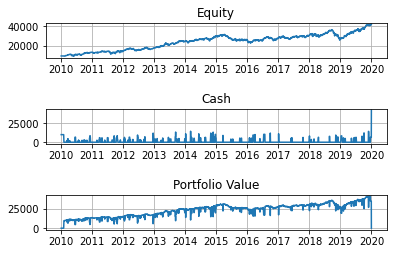

In [12]:
# 4.7 SimpleSimulator example usage

from pypm import metrics, signals, data_io, simulation
import pandas as pd

def simulate_portfolio():

    bollinger_n = 20
    sharpe_n = 20

    # Load in data
    symbols: List[str] = data_io.get_all_symbols()
    prices: pd.DataFrame = data_io.load_eod_matrix(symbols)

    # Use the bollinger band outer band crossorver as a signal
    _bollinger = signals.create_bollinger_band_signal
    signal = prices.apply(_bollinger, args=(bollinger_n,), axis=0)

    # Use a rolling sharpe ratio approximation as a preference matrix
    _sharpe = metrics.calculate_rolling_sharpe_ratio
    preference = prices.apply(_sharpe, args=(sharpe_n, ), axis=0)

    # Run the simulator
    simulator = simulation.SimpleSimulator(
        initial_cash=10000,
        max_active_positions=5,
        percent_slippage=0.0005,
        trade_fee=1,
    )
    simulator.simulate(prices, signal, preference)

    # Print results
    simulator.portfolio_history.print_position_summaries()
    simulator.print_initial_parameters()
    simulator.portfolio_history.print_summary()
    simulator.portfolio_history.plot()

if __name__ == '__main__':
    simulate_portfolio()